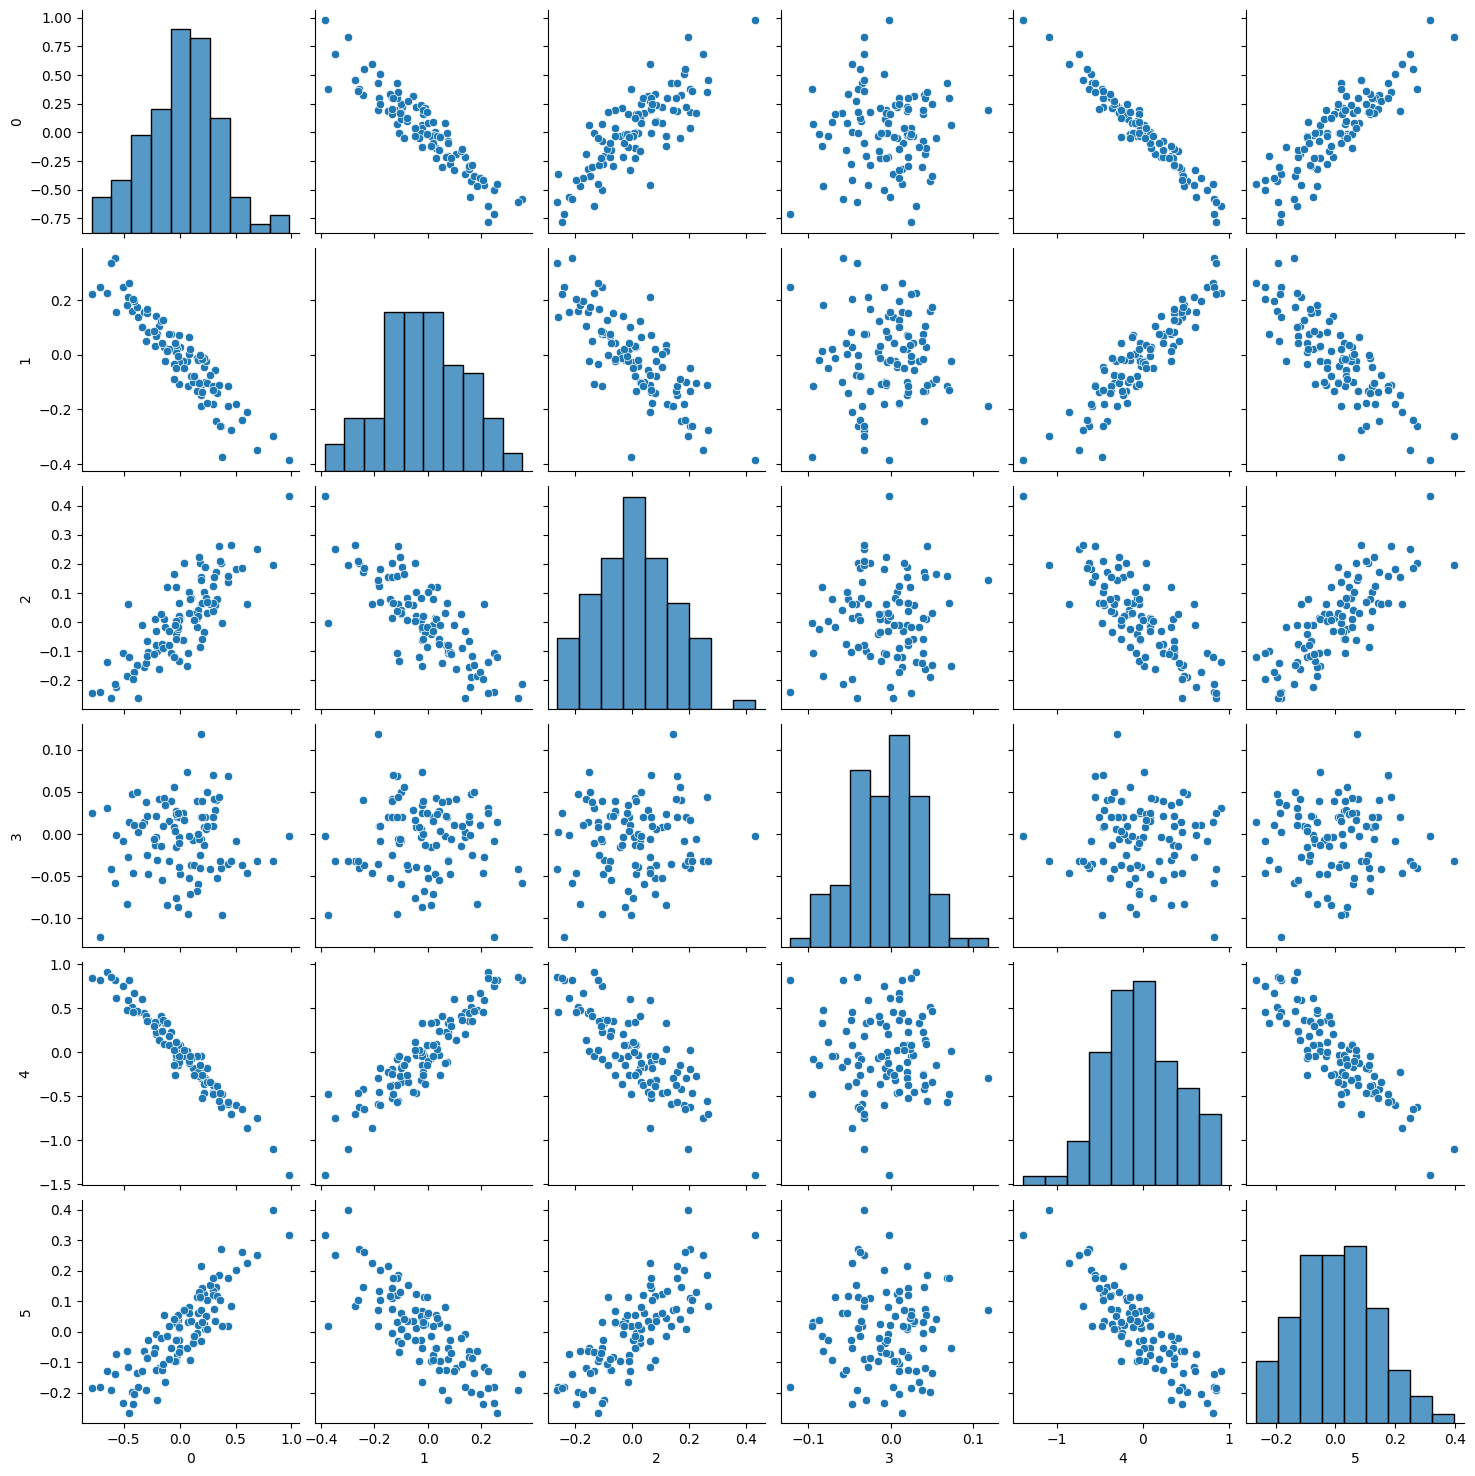

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import seaborn as sns

M = 6

mu = np.zeros(M)
Sig = np.array([[200,100,-30, 5,110, 3],
                [100,300,40,25,-2, 0],
                [-30,40,200,10, 0,-70],
                [ 5,25,10,500, 2, 0],
                [110,-2, 0, 2,100,60],
                [ 3, 0,-70, 0,60,300]])

X = np.random.multivariate_normal(mean=mu,cov=np.linalg.inv(Sig),size=100).T

sns.pairplot(pd.DataFrame(X.T))

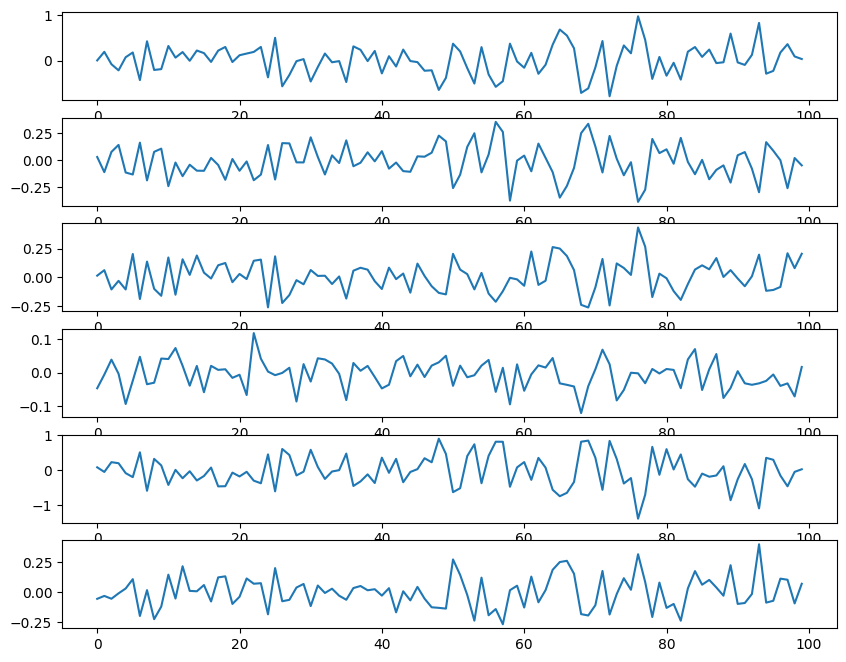

In [38]:
fig, ax = plt.subplots(6,1,figsize=(10,8))
for i in range(6):
    ax[i].plot(X[i].T);

In [2]:
def lasso(M, W, w, s, rho):
    beta = np.linalg.inv(W)@w

    b = True
    while b:
        A = s - W*(1-np.diag(np.ones(M-1)))@beta
        beta_new = ((A-rho) / np.diag(W).reshape(-1,1))*(A>rho).astype(int) + ((A+rho) / np.diag(W).reshape(-1,1))*(A<-rho).astype(int)
        beta_new[(-rho<=A)&(A<=rho)] = 0
        #b = np.any(beta!=beta_new)
        b = np.sum((beta-beta_new)**2) > 1e-9
        beta = beta_new.copy()
    return beta

def graphical_lasso(Lambda_inv, Lambda, S, M, i):
    idx = np.arange(M)[np.arange(M)!=i]
    W = Lambda_inv[idx,:][:,idx].copy()
    w = Lambda_inv[i:(i+1),idx].T.copy()
    sigma = Lambda_inv[i,i]

    l = Lambda[i:(i+1),idx].T.copy()
    s = S[i:(i+1),idx].T.copy()
    sii = S[i,i].copy()
    rho = np.mean((w-s)*np.sign(l))
    beta = lasso(M, W, w, s, rho)

    sigma = sii+rho
    w = W@beta

    lmd = 1/(sigma - beta.T@W@beta)
    l = - beta / (sigma - beta.T@W@beta)

    Lambda_inv[i,i] = sigma
    Lambda_inv[i:(i+1),idx] = w.T
    Lambda_inv[idx,i:(i+1)] = w
    
    Lambda[i,i] = lmd
    Lambda[i:(i+1),idx] = l.T
    Lambda[idx,i:(i+1)] = l
    return Lambda_inv, Lambda

X_std = ((X.T - np.mean(X, axis=1)) / np.sqrt(np.sum((X-np.mean(X, axis=1).reshape(-1,1))**2, axis=1)/X.shape[1])).T
S = X_std@X_std.T / X_std.shape[1]

Lambda_inv = S.copy()
Lambda = np.linalg.inv(Lambda_inv)

t = True
while t:
    Lambda_inv_before = Lambda_inv.copy()
    for i in range(M):
        Lambda_inv, Lambda = graphical_lasso(Lambda_inv, Lambda, S, M, i)
    t = np.sum((Lambda_inv-Lambda_inv_before)**2) > 1e-12

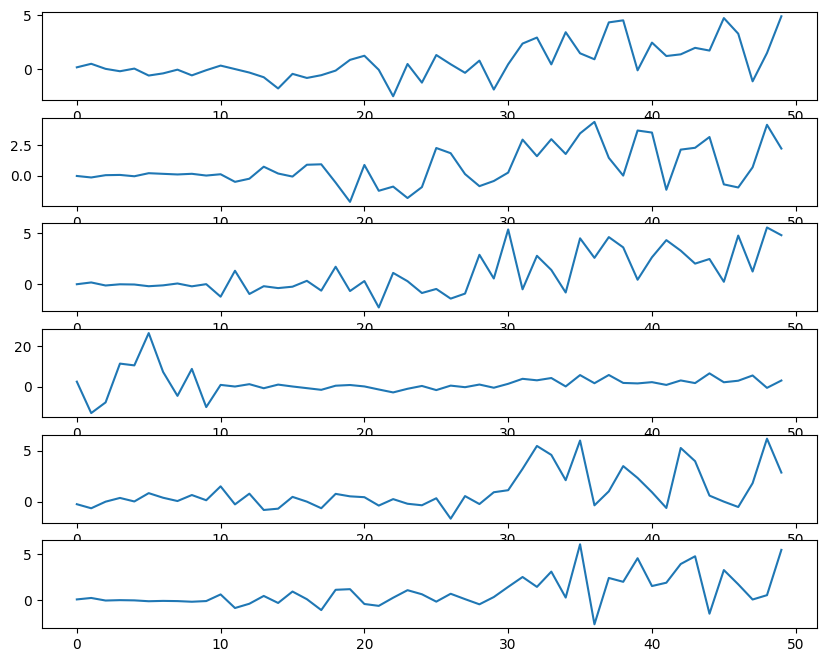

In [58]:
X_new = np.random.multivariate_normal(mean=mu,cov=np.linalg.inv(Sig),size=10).T
X_new[3,:] = np.random.normal(loc=5, scale=10, size=10)
X_new = np.concatenate([X_new, np.random.normal(loc=0, scale=1, size=(6,20))], axis=1)
X_new = np.concatenate([X_new, np.random.normal(loc=2, scale=2, size=(6,20))], axis=1)

fig, ax = plt.subplots(6,1,figsize=(10,8))
for i in range(6):
    ax[i].plot(X_new[i].T);

In [49]:
a = np.log(2*np.pi/np.diag(Lambda).reshape(-1,1))/2+1/(2*np.diag(Lambda).reshape(-1,1))*(Lambda@X_new)**2

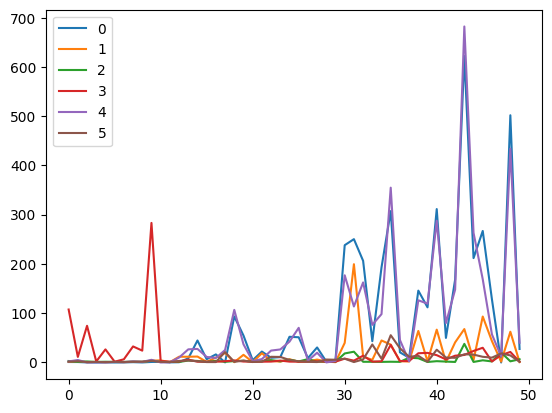

In [50]:
for i in range(6):
    plt.plot(a[i,:])
plt.legend(np.arange(M));

In [51]:
a = np.log(2*np.pi/np.diag(Lambda).reshape(-1,1))/2+1/(2*np.diag(Lambda).reshape(-1,1))*(Lambda@X)**2

(0.0, 100.0)

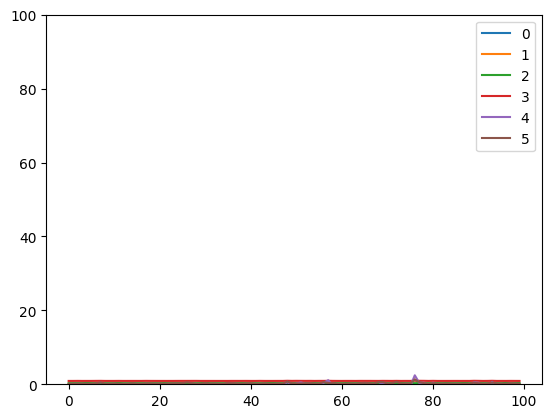

In [54]:
for i in range(6):
    plt.plot(a[i,:])
plt.legend(np.arange(M));
plt.ylim(0,100)

In [55]:
Sig_ng = np.array([[200,0,-30, 5,0, 3],
                   [0,300,40,25,-2, 0],
                   [-30,40,200,10, 0,-7],
                   [ 5,25,10,500, 2, 0],
                   [0,-2, 0, 2,100,60],
                   [ 3, 0,-7, 0,60,300]])
X_ng = np.random.multivariate_normal(mean=mu,cov=np.linalg.inv(Sig_ng),size=100).T

X_ng_std = ((X_ng.T - np.mean(X_ng, axis=1)) / np.sqrt(np.sum((X_ng-np.mean(X_ng, axis=1).reshape(-1,1))**2, axis=1)/X_ng.shape[1])).T
S_ng = X_ng_std@X_ng_std.T / X_ng_std.shape[1]

Lambda_inv_ng = S_ng.copy()
Lambda_ng = np.linalg.inv(Lambda_inv_ng)

t = True
while t:
    Lambda_inv_before = Lambda_inv_ng.copy()
    for i in range(M):
        Lambda_inv_ng, Lambda_ng = graphical_lasso(Lambda_inv_ng, Lambda_ng, S_ng, M, i)
    t = np.sum((Lambda_inv_ng-Lambda_inv_before)**2) > 1e-12

In [56]:
a = np.log(np.diag(Lambda).reshape(-1,1)/np.diag(Lambda_ng).reshape(-1,1)) - (np.diag(Lambda@S@Lambda).reshape(-1,1) / np.diag(Lambda).reshape(-1,1) - np.diag(Lambda_ng@S@Lambda_ng).reshape(-1,1) / np.diag(Lambda_ng).reshape(-1,1))/2

In [57]:
a

array([[3.25634204],
       [1.9059387 ],
       [1.02825427],
       [0.01635689],
       [2.98864851],
       [1.14469207]])

In [33]:
Sig - Sig_ng

array([[  0, 100,   0,   0, 110,   0],
       [100,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0, -63],
       [  0,   0,   0,   0,   0,   0],
       [110,   0,   0,   0,   0,   0],
       [  0,   0, -63,   0,   0,   0]])